In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 182 GB / percent used: 27.5 %


In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Variable
var = 'tas'
table = u.get_table(var)
    
var_label = 'Near-Surface Air Temperature [°C]'
var_label_trends = 'Near-Surface Air Temperature trends [°C/dec]'
var_label_bias = 'Near-Surface Air Temperature bias [°C]'
cmap='CoolWarm'
levels=plot.arange(-30,30,5)

# Load obs
## cru_ts4.00
More recent version available: https://crudata.uea.ac.uk/cru/data/hrg/  
-> pas évident à télécharger encore... les netCDF ne sont pas reconnus directement, je vais rester du coup sur la version 4.00  

```bash
cdo mergetime /bdd/cru/cru_ts_4.00/data/tmp/*.nc /data/mlalande/CRU/tmp/cru_ts4.00.1901.2015.tmp.dat.nc 
```

(pas plus rapide...)

Du coup je vais rester avec le open_mfdataset (même si le time n'est pas bien reconnu d'où le découpage à la main avec le isel)

See: http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/Temperature.ipynb

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


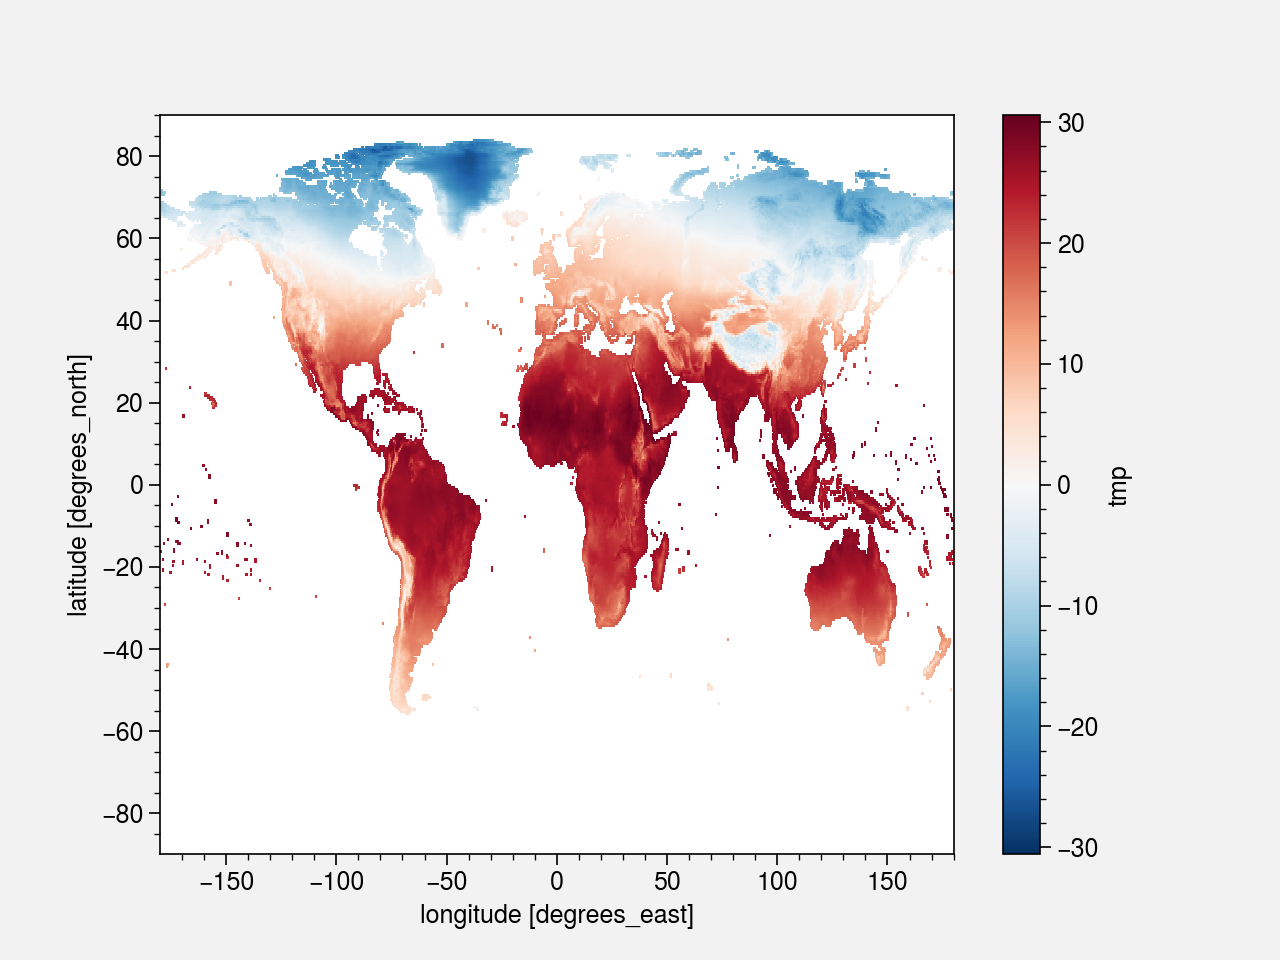

In [3]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs_clim = xr.open_mfdataset(
    '/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.*.tmp.dat.nc', combine='nested', concat_dim='time'
).isel(time=slice(1080,1488)).tmp.mean('time')
obs_clim.plot()

# Load model data
Get only models with tas, ta, ps, snc, for comparisons (http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/ta-global_multimodel/list_models.ipynb)


In [6]:
list_models = [
#     'BCC-CSM2-MR', 
#     'BCC-ESM1', 
#     'CESM2', 
#     'CESM2-FV2', 
#     'CESM2-WACCM', 
#     'CESM2-WACCM-FV2', 
#     'CanESM5', 
#     'EC-Earth3-Veg', 
    'FGOALS-f3-L', 
#     'GFDL-CM4', 
#     'GISS-E2-1-G', 
#     'GISS-E2-1-G-CC', 
#     'GISS-E2-1-H', 
#     'IPSL-CM6A-LR', 
#     'MIROC6', 
#     'MPI-ESM1-2-HR', 
#     'MPI-ESM1-2-LR', 
#     'MRI-ESM2-0', 
#     'NorCPM1', 
#     'NorESM2-LM', 
#     'SAM0-UNICON'
]

realization = 'r1i1p1f1'

bias = []

for model in list_models:
    print(model)
    institute, grid = u.select_model(model, var)
    model_clim = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', combine='by_coords'
    ).sel(time=period)[var].mean('time')-273.15
    
    # Regrid towards model
    regridder = xe.Regridder(obs_clim, model_clim, 'bilinear', periodic=True, reuse_weights=True)
    obs_clim_regrid = regridder(obs_clim)
    
    bias.append(model_clim - obs_clim_regrid)

FGOALS-f3-L
Reuse existing file: bilinear_360x720_180x288_peri.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


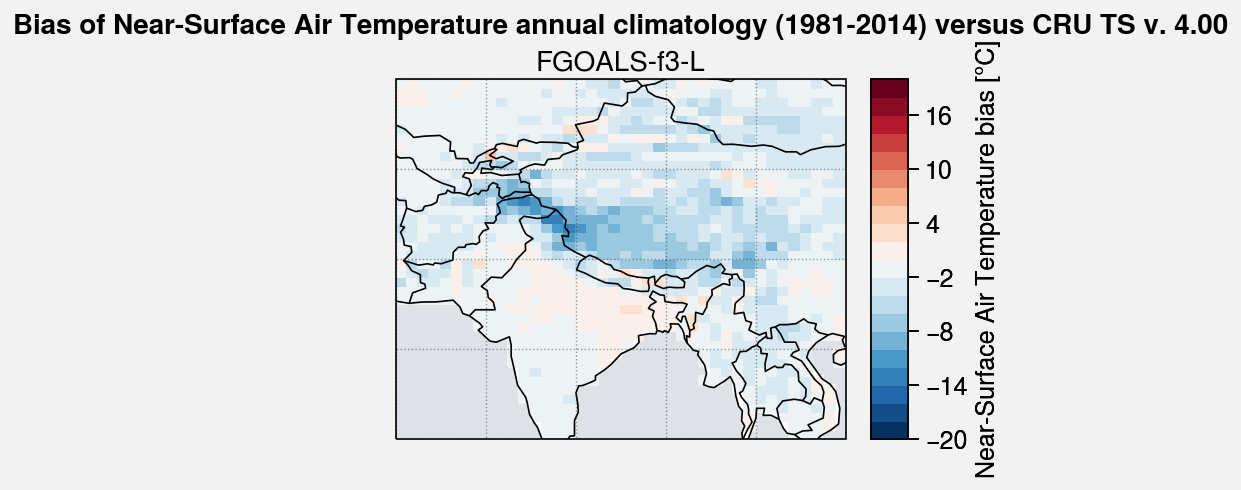

In [7]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1)

for i, ax in enumerate(axs):
    #Plot
    m = axs[i].pcolormesh(bias[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), cmap='RdBu_r', levels=plot.arange(-20,20,2))
    axs[i].format(title=list_models[i])
    
    
f.colorbar(m, label=var_label_bias, loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Bias of Near-Surface Air Temperature annual climatology (1981-2014) versus "+obs_longname,
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)